### Imports and Setup

In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.manifold import TSNE
from IPython.display import HTML

# --- Path Setup ---
# Add the parent directory to system path to import local modules
sys.path.append(os.path.abspath(os.path.join('..')))

# --- Local Imports ---
from models.dann import DANN_Model
from data.mnist_m import get_dataloaders
from utils.lambda_schedule import get_lambda

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
print(f"Running on: {DEVICE}")


Running on: cpu


### Data & Helper Functions

In [2]:
# --- Load Data ---
# We use the same loaders as the training script
source_loader, target_loader, _ = get_dataloaders(BATCH_SIZE)

def extract_features(model, loader_s, loader_t, max_samples=300):
    """
    Passes data through the Feature Extractor to get the embedding vector.
    Returns numpy arrays of features and domain labels (0=Source, 1=Target).
    """
    model.eval()
    
    feats_s = []
    feats_t = []
    
    # Extract Source Features (Label = 0)
    with torch.no_grad():
        count = 0
        for imgs, _ in loader_s:
            imgs = imgs.to(DEVICE)
            f = model.feature_extractor(imgs).view(imgs.size(0), -1)
            feats_s.append(f.cpu().numpy())
            count += len(imgs)
            if count >= max_samples: break
            
    # Extract Target Features (Label = 1)
    with torch.no_grad():
        count = 0
        for imgs, _ in loader_t:
            imgs = imgs.to(DEVICE)
            f = model.feature_extractor(imgs).view(imgs.size(0), -1)
            feats_t.append(f.cpu().numpy())
            count += len(imgs)
            if count >= max_samples: break
            
    # Concatenate results
    feats_s = np.concatenate(feats_s)[:max_samples]
    feats_t = np.concatenate(feats_t)[:max_samples]
    
    all_feats = np.concatenate([feats_s, feats_t])
    # Create labels: 0 for Source, 1 for Target
    domain_labels = np.concatenate([np.zeros(len(feats_s)), np.ones(len(feats_t))])
    
    return all_feats, domain_labels

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.14MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 296kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.13MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.15MB/s]


### Live Training & Snapshot Capture

In [5]:
# --- Setup Animation Training ---
# We initialize a FRESH model to show the evolution from scratch
model = DANN_Model().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion_class = torch.nn.CrossEntropyLoss()
criterion_domain = torch.nn.BCEWithLogitsLoss()

# Store features for each "snapshot" (epoch)
snapshots = []
epochs_to_animate = 10  # Keep it short for the demo (e.g., 5-10 epochs)

print("Starting Live Training for Animation...")

# 0. Capture initial state (Untrained)
print("Capturing Epoch 0 (Untrained)...")
f, l = extract_features(model, source_loader, target_loader)
snapshots.append((f, l, "Epoch 0 (Untrained)"))

# Training Loop
for epoch in range(epochs_to_animate):
    model.train()
    len_dataloader = min(len(source_loader), len(target_loader))
    alpha = get_lambda(epoch, epochs_to_animate) # Dynamic alpha 

    for i, ((data_s, label_s), (data_t, _)) in enumerate(zip(source_loader, target_loader)):
        data_s, label_s = data_s.to(DEVICE), label_s.to(DEVICE)
        data_t = data_t.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Source Forward (CORREGIDO: Esperamos solo 2 valores)
        class_out, domain_out_s = model(data_s, alpha=alpha)
        
        loss_s_label = criterion_class(class_out, label_s)
        loss_s_domain = criterion_domain(domain_out_s, torch.zeros(data_s.size(0), 1).to(DEVICE))
        
        # Target Forward (CORREGIDO: Esperamos solo 2 valores)
        _, domain_out_t = model(data_t, alpha=alpha)
        
        loss_t_domain = criterion_domain(domain_out_t, torch.ones(data_t.size(0), 1).to(DEVICE))
        
        # Backward (GRL handles the gradient reversal automatically)
        loss = loss_s_label + loss_s_domain + loss_t_domain
        loss.backward()
        optimizer.step()
    
    # Capture snapshot at end of epoch
    print(f"Capturing Epoch {epoch+1}...")
    f, l = extract_features(model, source_loader, target_loader)
    snapshots.append((f, l, f"Epoch {epoch+1} (Alpha: {alpha:.2f})"))

print("Data collection complete.")

Starting Live Training for Animation...
Capturing Epoch 0 (Untrained)...
Capturing Epoch 1...
Capturing Epoch 2...
Capturing Epoch 3...
Capturing Epoch 4...
Capturing Epoch 5...
Capturing Epoch 6...
Capturing Epoch 7...
Capturing Epoch 8...
Capturing Epoch 9...
Capturing Epoch 10...
Data collection complete.


### Compute t-SNE and Generate Animation

Computing t-SNE for each frame (this might take a minute)...
Processing frame 1/11...
Processing frame 2/11...
Processing frame 3/11...
Processing frame 4/11...
Processing frame 5/11...
Processing frame 6/11...
Processing frame 7/11...
Processing frame 8/11...
Processing frame 9/11...
Processing frame 10/11...
Processing frame 11/11...


Animation generated!


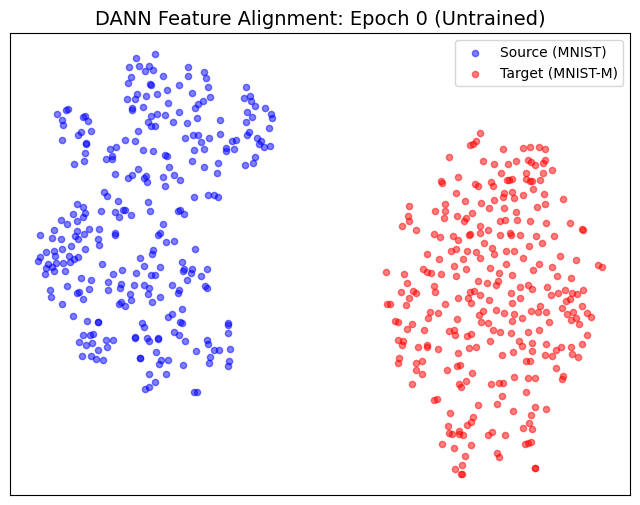

In [ ]:
# --- Generate t-SNE for each snapshot ---
# Note: t-SNE is stochastic. We run it separately for each frame.
# Ideally, one might use PCA for smoother animations, but t-SNE shows clusters better.

tsne_results = []
print("Computing t-SNE for each frame (this might take a minute)...")

tsne = TSNE(n_components=2, perplexity=30, random_state=42)

for i, (features, labels, title) in enumerate(snapshots):
    print(f"Processing frame {i+1}/{len(snapshots)}...")
    # Compute 2D embedding
    embed = tsne.fit_transform(features)
    tsne_results.append((embed, labels, title))

# --- Build the Animation ---
fig, ax = plt.subplots(figsize=(8, 6))

def update(frame_idx):
    ax.clear()
    embed, labels, title = tsne_results[frame_idx]
    
    # Plot Source (Blue)
    ax.scatter(embed[labels==0, 0], embed[labels==0, 1], 
               c='blue', alpha=0.5, s=20, label='Source (MNIST)')
    
    # Plot Target (Red)
    ax.scatter(embed[labels==1, 0], embed[labels==1, 1], 
               c='red', alpha=0.5, s=20, label='Target (MNIST-M)')
    
    ax.set_title(f"DANN Feature Alignment: {title}", fontsize=14)
    ax.legend(loc='upper right')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax,

# Create animation object
ani = animation.FuncAnimation(fig, update, frames=len(tsne_results), interval=800)

# To display in Jupyter, use HTML5 video
# Make sure you have ffmpeg installed, or simply run plt.show() for a window
try:
    display(HTML(ani.to_jshtml()))
except:
    print("Could not render HTML5 video. Showing static plot of last frame instead.")
    plt.show()

# Option to save as GIF (requires ImageMagick or Pillow)
# ani.save('dann_training_process.gif', writer='pillow', fps=1)
print("Animation generated!")